<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Cell-Metadata" data-toc-modified-id="Cell-Metadata-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Cell Metadata</a></span></li><li><span><a href="#Adata" data-toc-modified-id="Adata-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Adata</a></span></li></ul></li><li><span><a href="#Scale" data-toc-modified-id="Scale-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Scale</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>PCA</a></span><ul class="toc-item"><li><span><a href="#mCH" data-toc-modified-id="mCH-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>mCH</a></span></li><li><span><a href="#Concatenate" data-toc-modified-id="Concatenate-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Concatenate</a></span></li></ul></li><li><span><a href="#KNN" data-toc-modified-id="KNN-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>KNN</a></span></li><li><span><a href="#Simple-Leiden" data-toc-modified-id="Simple-Leiden-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Simple Leiden</a></span></li><li><span><a href="#UMAP" data-toc-modified-id="UMAP-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>UMAP</a></span></li><li><span><a href="#tSNE" data-toc-modified-id="tSNE-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>tSNE</a></span></li><li><span><a href="#Save-adata" data-toc-modified-id="Save-adata-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Save adata</a></span></li><li><span><a href="#Get-cell-tidy-data" data-toc-modified-id="Get-cell-tidy-data-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Get cell tidy data</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Plotting</a></span><ul class="toc-item"><li><span><a href="#Metadata-cols" data-toc-modified-id="Metadata-cols-14.1"><span class="toc-item-num">14.1&nbsp;&nbsp;</span>Metadata cols</a></span></li></ul></li></ul></div>

# Dimension Reduction and Manifold Learning

## Purpose
- PCA or batch corrected PCA
- Simple Leiden clustering
- UMAP and tSNE

## Input
- mCH HVF adata
- mCG HVF adata

## Output
- integrated adata with PC matrix
- cell tidy data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc
import seaborn as sns
from ALLCools.mcds.MCDS import MCDS
from cemba_data.plot import *
from cemba_data.tools.hdf5.anndata import batch_correct_pc

In [3]:
result_dir = pathlib.Path('Coords')
result_dir.mkdir(exist_ok=True)
fig_dir = pathlib.Path('fig/dimension_reduction')
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell

ch_pc_components = 30
cg_pc_components = 15
pc_color_col = None

batch_correction_col = None
sigma = 15
alpha = 0.1
scanorama_k = 25

n_neighbors = 25
resolution = 0.8

perplexity = 50

metadata_category_cols = ['Region']
metadata_continue_cols = ['CG_RateAdj', 'CH_RateAdj', 'FinalReads']

cell_meta_path = 'RS2_PT.4176cells.meta.hdf'
ch_adata_path = './Adata/mch_adata.norm_per_cell.hvf.h5ad'
cg_adata_path = './Adata/mcg_adata.norm_per_cell.hvf.h5ad'

## Load

### Cell Metadata

In [5]:
cell_meta = pd.read_hdf(cell_meta_path, key='data')

### Adata

In [6]:
ch_adata = anndata.read_h5ad(ch_adata_path)

In [7]:
# snmC PT cells
rs1_adata = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/PT-L5/Adata/mch_adata.norm_per_cell.hvf.h5ad'
)

In [11]:
use_var = rs1_adata.var_names & ch_adata.var_names

ch_adata = ch_adata[:, use_var].copy()
ch_adata.obs['Dataset'] = 'RS2'

rs1_adata = rs1_adata[:, use_var].copy()
rs1_adata.obs['Dataset'] = 'RS1'

use_var.size

1925

In [13]:
total = rs1_adata.concatenate(ch_adata)

In [14]:
total

AnnData object with n_obs × n_vars = 6814 × 1925 
    obs: 'Dataset', 'batch'

## Scale

In [15]:
sc.pp.scale(total)

## PCA

### mCH

In [17]:
batch_correction_col = 'Dataset'
total = batch_correct_pc(
    total,
    correct=True,
    batch_series=total.obs[batch_correction_col],
    dimred=50,
    sigma=sigma,
    alpha=alpha,
    knn=scanorama_k,
    metric='angular')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Found 1925 genes among all datasets
[[0.         0.84609553]
 [0.         0.        ]]
Processing datasets (0, 1)


In [20]:
%matplotlib inline

In [22]:
sc.pl.pca(total,
          components=[
              '1,2', '3,4', '5,6', '7,8', '9,10', '11,12', '13,14', '15,16',
              '17,18', '19,20', '21,22', '23,24', '25,26', '27,28', '29,30',
          ],
          color='Dataset')

### Concatenate

In [25]:
total_pca = np.concatenate([
    total.obsm['X_pca'][:, :20]
],
                           axis=1)
adata = total.copy()
adata.obsm['X_pca'] = total_pca

## KNN

In [26]:
sc.pp.neighbors(adata, n_neighbors=n_neighbors)

## Simple Leiden

In [27]:
sc.tl.leiden(adata, resolution=resolution)

## UMAP

In [29]:
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata)
sc.tl.umap(
    adata,
    min_dist=0.5,
    spread=1.0,
    n_components=2,
    maxiter=None,
    alpha=1.0,
    gamma=1.0,
    negative_sample_rate=5,
)

## tSNE

In [30]:
sc.tl.tsne(adata, n_jobs=40, perplexity=perplexity)

## Save adata

In [31]:
adata.write_h5ad(result_dir / 'adata.with_pc_and_coords.h5ad')

## Get cell tidy data

In [32]:
def get_cell_tidy_data(adata, cell_meta):
    cell_meta = cell_meta.copy()
    cell_tidy_data = pd.DataFrame([], index=cell_meta.index)
    for col_name, col in adata.obs.iteritems():
        cell_tidy_data[col_name] = col
        try:
            del cell_meta[col_name]
        except KeyError:
            pass
    
    for k, v in adata.obsm.items():
        coord_name = k[2:]
        for i in range(2):
            cell_tidy_data[f'{coord_name}_{i}'] = v[:, i]
            try:
                del cell_meta[f'{coord_name}_{i}']
            except KeyError:
                pass
    cell_tidy_data = pd.concat(
        [cell_meta.reindex(adata.obs_names), cell_tidy_data],
        sort=True,
        axis=1)
    return cell_tidy_data

In [59]:
total_tidy_data = adata.obs.copy()
total_tidy_data['rs1rs2umap_0'] = adata.obsm['X_umap'][:, 0]
total_tidy_data['rs1rs2umap_1'] = adata.obsm['X_umap'][:, 1]
total_tidy_data['rs1rs2tsne_0'] = adata.obsm['X_tsne'][:, 0]
total_tidy_data['rs1rs2tsne_1'] = adata.obsm['X_tsne'][:, 1]

rs1_tidy_data = total_tidy_data[total_tidy_data['Dataset'] == 'RS1'][[
    'leiden', 'rs1rs2umap_0', 'rs1rs2umap_1', 'rs1rs2tsne_0', 'rs1rs2tsne_1'
]]
rs2_tidy_data = total_tidy_data[total_tidy_data['Dataset'] == 'RS2'][[
    'leiden', 'rs1rs2umap_0', 'rs1rs2umap_1', 'rs1rs2tsne_0', 'rs1rs2tsne_1'
]]

rs1_tidy_data.index = rs1_tidy_data.index.str[:-2]
rs2_tidy_data.index = rs2_tidy_data.index.str[:-2]


In [60]:
rs1_tidy_data.to_hdf('RS1.integrate_tidy_data.hdf', key='data', format="table")
rs2_tidy_data.to_hdf('RS2.integrate_tidy_data.hdf', key='data', format="table")

In [61]:
cell_tidy_data = pd.concat([cell_meta, rs2_tidy_data], axis=1, sort=True)

## Plotting

In [63]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), dpi=300, ncols=2)
categorical_scatter(cell_tidy_data,
                    ax1,
                    coord_base='rs1rs2umap',
                    hue='leiden',
                    text_anno='leiden',
                    text_anno_kws=dict(fontsize=6))
categorical_scatter(cell_tidy_data,
                    ax2,
                    coord_base='rs1rs2tsne',
                    hue='leiden',
                    text_anno='leiden',
                    text_anno_kws=dict(fontsize=6))
# fig.savefig(fig_dir / 'leiden.on_umap_tsne.pdf')
pass

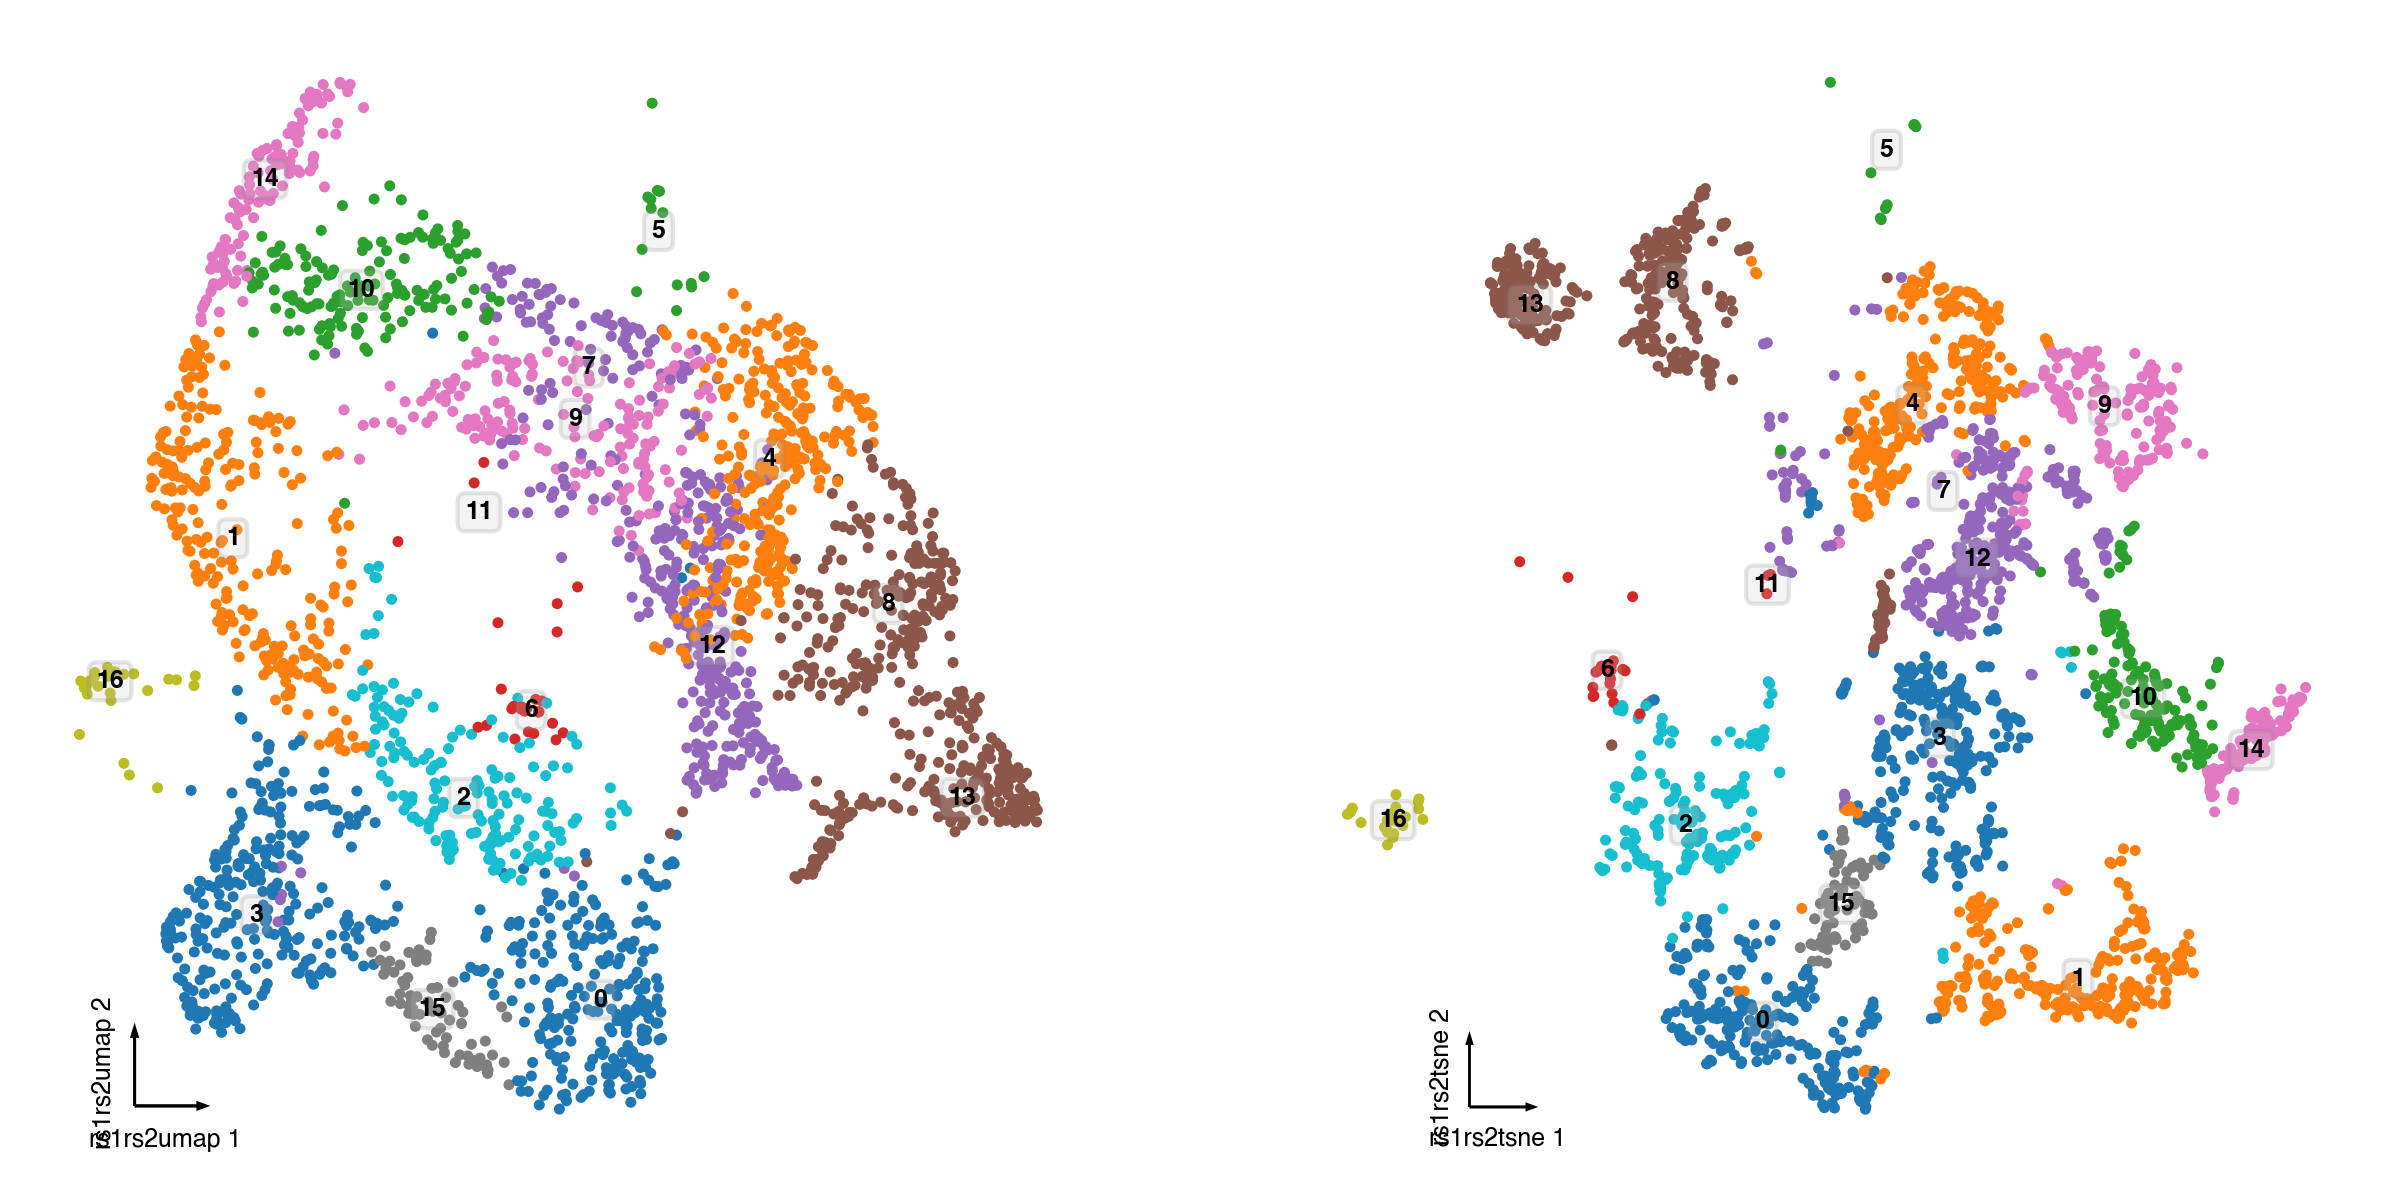

In [68]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), dpi=300, ncols=2)
categorical_scatter(rs1_tidy_data,
                    ax1,
                    coord_base='rs1rs2umap',
                    hue='leiden',
                    text_anno='leiden',
                    text_anno_kws=dict(fontsize=6))
categorical_scatter(rs1_tidy_data,
                    ax2,
                    coord_base='rs1rs2tsne',
                    hue='leiden',
                    text_anno='leiden',
                    text_anno_kws=dict(fontsize=6))
# fig.savefig(fig_dir / 'leiden.on_umap_tsne.pdf')
pass

### Metadata cols

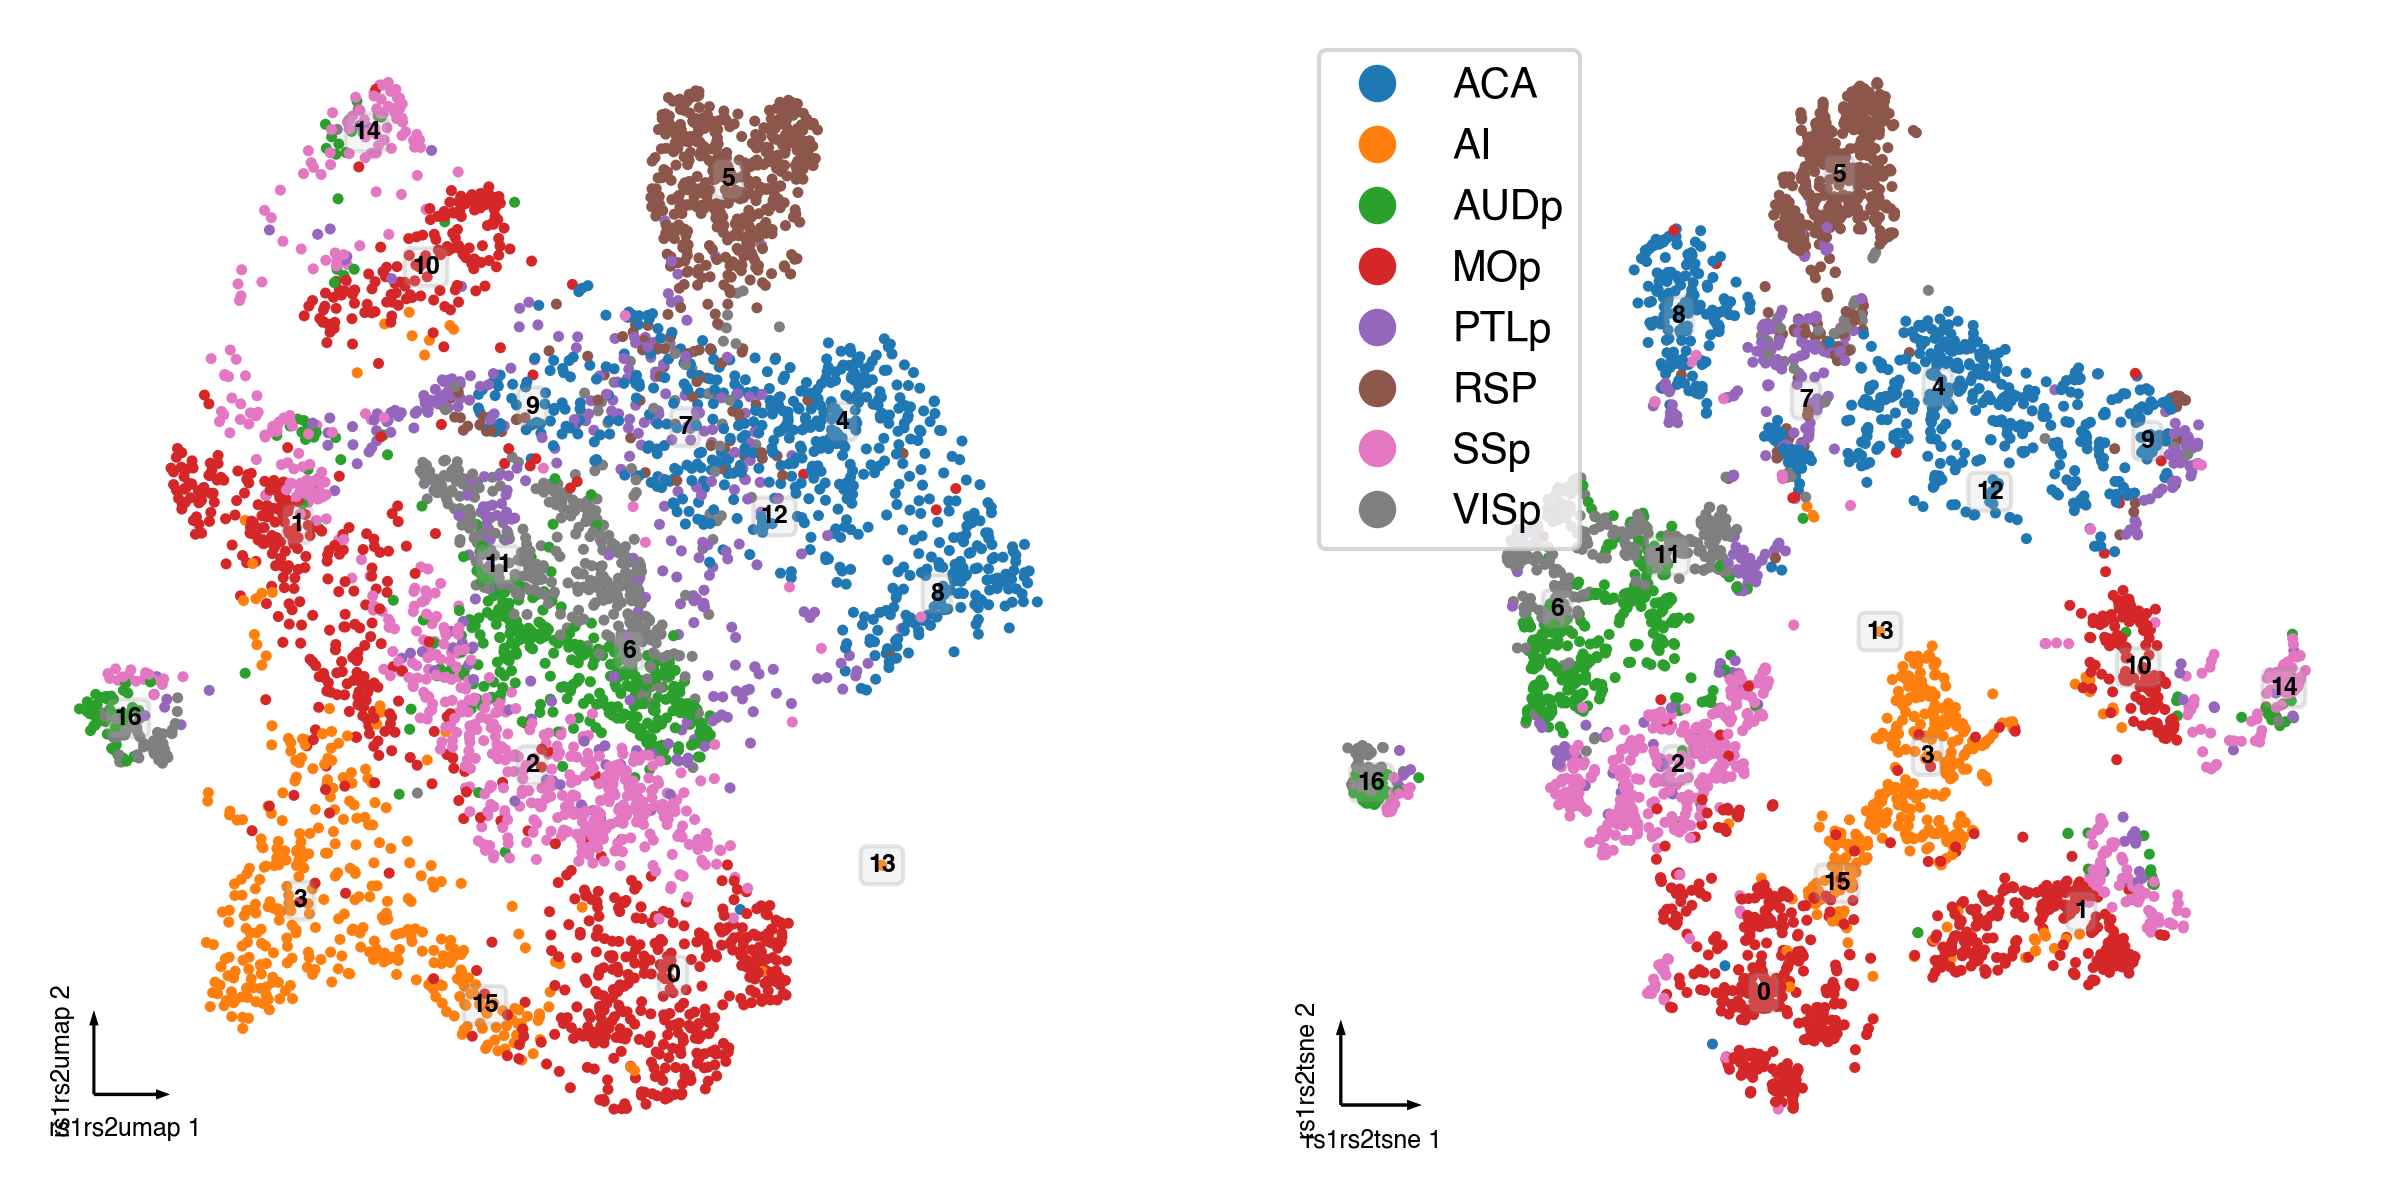

In [66]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), dpi=300, ncols=2)
categorical_scatter(cell_tidy_data,
                    ax1,
                    coord_base='rs1rs2umap',
                    hue='source',
                    text_anno='leiden',
                    text_anno_kws=dict(fontsize=6))
categorical_scatter(cell_tidy_data,
                    ax2,
                    coord_base='rs1rs2tsne',
                    hue='source',
                    text_anno='leiden',
                    show_legend=True,
                    text_anno_kws=dict(fontsize=6))
# fig.savefig(fig_dir / 'leiden.on_umap_tsne.pdf')
pass

In [67]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), dpi=300, ncols=2)
categorical_scatter(cell_tidy_data,
                    ax1,
                    coord_base='rs1rs2umap',
                    hue='target',
                    text_anno='leiden',
                    text_anno_kws=dict(fontsize=6))
categorical_scatter(cell_tidy_data,
                    ax2,
                    coord_base='rs1rs2tsne',
                    hue='target',
                    text_anno='leiden',
                    show_legend=True,
                    text_anno_kws=dict(fontsize=6))
# fig.savefig(fig_dir / 'leiden.on_umap_tsne.pdf')


In [71]:
cell_tidy_data.to_hdf('RS2_PT_tidy_data_with_integration.hdf', key='data', format='table')